Author: Nathaniel Ruhl
This notebook contains the graphs with different angles of a horizon crossing and the potential in-track position accuracy. This contains many of the conclusions of our end-of-summer 2020 paper.

In [1]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
import datetime
import numbers
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices of full crossing
startTimeIndex = 311869
stopTimeIndex = 449115

startMKF = 2264 - 15 #exact start at -18...missing some data points before
stopMKF = 2374 + 184

# read in the data files
tabMKF = Table.read('ni2200300102.mkf', hdu=1)
timeMKF = np.array(tabMKF['TIME'][startMKF:stopMKF])
elevMKF = np.array(tabMKF['ELV'][startMKF:stopMKF])
ramMKF = np.array(tabMKF['RAM_ANGLE'][startMKF:stopMKF])
pointing_unit = np.array(tabMKF['PNTUNIT'][startMKF:stopMKF])
position = np.array(tabMKF['POSITION'][startMKF:stopMKF])
position_mag = np.array(np.sqrt((position[:,0])**2+(position[:,1])**2+(tabMKF['POSITION'][startMKF:stopMKF][:,2])**2))
velocity = np.array(tabMKF['VELOCITY'][startMKF:stopMKF])
velocity_mag = np.array(np.sqrt((velocity[:,0])**2+(velocity[:,1])**2+(velocity[:,2])**2))
# make unit vectors
for col in range(3):
    velocity[:,col] = velocity[:,col]/velocity_mag
    position[:,col] = position[:,col]/position_mag
pole_vec = np.cross(position,velocity)

# calculate orbital phase angle
ascending_node = np.cross(pole_vec, [0,0,1])
ascending_mag = np.sqrt(ascending_node[:,0]**2 + ascending_node[:,1]**2)
for col in range(3):
    ascending_node[:,col] = ascending_node[:,col]/ascending_mag
orbital_phase = np.rad2deg(np.arccos(ascending_node[:,0]*position[:,0] + ascending_node[:,1]*position[:,1] + ascending_node[:,2]*position[:,2]))
# It has to be p cross z, or else we are not moving away from the ascending node

R = 6378
H = 419
theta = np.arcsin(R/(R+H))
beta = elevMKF + np.rad2deg(theta)

#Tangent altitude of line of sight is based on elevation angle
altMKF = []
for indx, val in enumerate(elevMKF):
    h = (((R+H)*np.sin(theta+val*(np.pi/180)))-R)
    altMKF.append(h)
altMKF = np.array(altMKF)
betaMKF = np.rad2deg(np.arcsin((R+altMKF)/(R+H)))

tabEVT = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tabEVT['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tabEVT['PI'][startTimeIndex:stopTimeIndex])

newCalcElev = np.arange(np.min(np.deg2rad(elevMKF)),(np.pi/2)-theta,0.0011267) # this is the value from the convolution period.
newCalcElev=list(newCalcElev)
newCalcElev.pop(len(newCalcElev)-1)
newCalcElev = np.array(newCalcElev)

# We have to sync up the two data files
def Interpolator(col_mkf):
    f = interpolate.interp1d(timeMKF, col_mkf, kind='linear')
    return f(eventTime)

elev_evt = Interpolator(elevMKF)
ram_evt = Interpolator(ramMKF)
Xcoord = Interpolator(position[:,0])
Ycoord = Interpolator(position[:,1])
Zcoord = Interpolator(position[:,2])
phase_evt = Interpolator(orbital_phase)
newCalcElev = Interpolator(newCalcElev)

newTangentAlt = (R+H)*np.sin(theta + newCalcElev)-R


# calculate tangent altitude based on elevation angle
altArray = []
for indx, val in enumerate(elev_evt):
    h = (((R+H)*np.sin(theta+val*(np.pi/180)))-R)
    altArray.append(np.float(h))
altArray = np.array(altArray)
#beta = np.arcsin((R+altArray)/(R+H))

# read in MSIS model data
data = ascii.read("msis_419.txt")

height = np.array(data['h'])
density = np.array(data['dens'])
temp = np.array(data['T'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)

In [2]:
# constants
binSize_all = 1
k = 1.38064852e-23
mu = 28
mp = 1.6726219e-27
g = 9.8
# L = (k*T)/(1000*mu*mp*g)
z0 = 135
# p0 = 0.0012*np.exp(-z0/L)


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = EnergyBands.enSplit(self)
        self.alt, self.elev, self.phase, self.calcAlt = EnergyBands.altSplit(self)
        self.rate, self.binnedElev, self.new_alt, self.binTime, self.binnedEnergy, self.binnedX, self.binnedY, self.binnedZ, self.binnedPhase, self.binnedCalcAlt = EnergyBands.countRate(self)
        self.T_pre = EnergyBands.msisSplit(self, msisT)
        self.rho_pre = EnergyBands.msisSplit(self, msisRho)
        self.rho_msis, self.T_msis = EnergyBands.countRateSync(self)
        self.perc_trans = EnergyBands.percTrans(self)
        self.trans_model = EnergyBands.Transmit2(self)
        self.rate_model = EnergyBands.Transmit3(self)

    # function that splits the altitudes based on energy bands
    def altSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (enArray < self.energy_band[1]))
        return altArray[index[0]], elev_evt[index[0]], phase_evt[index[0]], newTangentAlt[index[0]]

    # function that deduces the number of counts per bin size
    def countRate(self):
        binCounts = []
        binTime = []
        altitude = []
        binnedEnergy = []
        binnedX = []
        binnedY = []
        binnedZ = []
        binElev = []
        binnedPhase = []
        binnedCalcAlt = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0:
                binCounts.append(np.size(desind[0]))
                altitude.append(np.mean(self.alt[desind[0]]))
                binTime.append(np.mean(self.time[desind[0]]))
                binnedEnergy.append(np.mean(self.energies[desind[0]]))
                binnedX.append(np.mean(Xcoord[desind[0]]))
                binnedY.append(np.mean(Ycoord[desind[0]]))
                binnedZ.append(np.mean(Zcoord[desind[0]]))
                binElev.append(np.mean(self.elev[desind[0]]))
                binnedPhase.append(np.mean(self.phase[desind[0]]))
                binnedCalcAlt.append(np.mean(self.calcAlt[desind[0]]))
        return np.array(binCounts), np.array(binElev), np.array(altitude), np.array(binTime), np.array(binnedEnergy), np.array(binnedX), np.array(binnedY), np.array(binnedZ), np.array(binnedPhase), np.array(binnedCalcAlt)

    def msisSplit(self, msis_col):
        index = np.where((enArray >= self.energy_band[0]) & (enArray < self.energy_band[1]))
        return msis_col[index[0]]

    def countRateSync(self):
        rho = []
        temp = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0.:
                rho.append(np.mean(self.rho_pre[desind[0]]))
                temp.append(np.mean(self.T_pre[desind[0]]))
        return np.array(rho), np.array(temp)

    # function that makes a list of times corresponding to each energy range
    def enSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return eventTime[index[0]], enArray[index[0]]/100

    def percTrans(self):
        plateau = np.where(((self.new_alt > 200) & (self.new_alt < 250)))
        avg = np.mean(self.rate[plateau[0]])
        return (self.rate/avg)*100
    
    @property
    def normFactor(self):
        plateau = np.where(((self.new_alt > 200) & (self.new_alt < 250)))
        avg = np.mean(self.rate[plateau[0]])
        return avg

    # functions for the atmospheric model
    @property
    def atmHeight(self):
        return np.array((k*self.T_msis)/(1000*mu*mp*g))

    # using the equation found from fitting sigma originally (msis_edge.ipynb)
    @property
    def sigmaTrend(self):
        c = np.float(-3)
        return (416.21)*(self.binnedEnergy)**c - 33.4 #(274.6)*(self.binnedEnergy)**c + 11.6  
    
    def Z_x(self, hi, x):
        z = np.int(np.sqrt((R+self.new_alt[hi])**2+x**2)-R)
        if z > (len(self.new_alt)-1):
            return len(self.new_alt)-1
        else:
            return z

    def Transmit2(self):
        tau = []
        halfDist = np.sqrt((R+H)**2-(R+self.new_alt)**2)
        for hi in range(len(self.new_alt)):
            g = 0
            intStepSize = 1
            upperBound1 = halfDist[hi]
            upperBound2 = 1000  # 1000km
            X1 = np.arange(0, upperBound1, intStepSize)
            #X2 = np.arange(0, upperBound2, intStepSize)
            for n in X1:
                g += self.rho_msis[hi]*intStepSize*10**5 #EnergyBands.Z_x(self, hi, n)

            tau.append(2*self.sigmaTrend[hi]*g)
        tau = np.array(tau)
        trans = np.exp(-tau)*100
        return trans
    
    def Transmit3(self):
        tau = []
        halfDist = np.sqrt((R+H)**2-(R+self.new_alt)**2)
        for hi in range(len(self.new_alt)):
            g = 0
            intStepSize = 1
            upperBound1 = halfDist[hi]
            X1 = np.arange(0, upperBound1, intStepSize)
            for n in X1:
                g += self.rho_msis[hi]*intStepSize*10**5 #EnergyBands.Z_x(self, hi, n)

            tau.append(2*self.sigmaTrend[hi]*g)
        tau = np.array(tau)
        trans = np.exp(-tau)
        return trans*self.normFactor

In [3]:
# Energy Band cutoffs
lowEn = [30,70]
newEnRange = [80, 100] #0.8-1.0 keV
midEn = [100, 140]
allEn = [0, 600]
all_en = EnergyBands(allEn, binSize_all)
mid_en = EnergyBands(midEn, binSize_all)
low_en = EnergyBands(lowEn, binSize_all)
newEn = EnergyBands(newEnRange, binSize_all)

Power_divergenceResult(statistic=31.126301999780523, pvalue=5.892589788552626e-05)

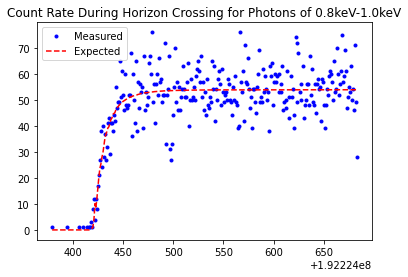

In [4]:
from scipy import stats
plt.plot(newEn.binTime, newEn.rate, 'b.', label='Measured')
plt.plot(newEn.binTime, newEn.rate_model, 'r--', label='Expected')
#plt.plot(mid_en.binTime, mid_en.rate, 'b.')
#plt.plot(mid_en.binTime, mid_en.rate_model, 'r--')
plt.title(f'Count Rate During Horizon Crossing for Photons of {newEnRange[0]/100}keV-{newEnRange[1]/100}keV')
plt.legend()
stats.chisquare(newEn.rate[10:18], newEn.rate_model[10:18])

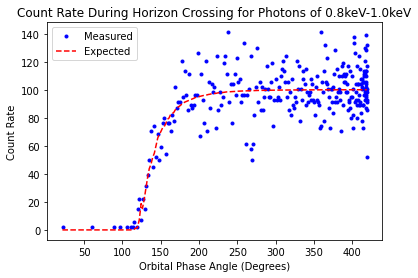

In [5]:
plt.plot(newEn.new_alt, newEn.perc_trans, 'b.', label='Measured')
plt.plot(newEn.binnedCalcAlt, newEn.trans_model, 'r--', label='Expected')
plt.title(f'Count Rate During Horizon Crossing for Photons of {newEnRange[0]/100}keV-{newEnRange[1]/100}keV')
plt.xlabel('Orbital Phase Angle (Degrees)')
plt.ylabel('Count Rate')
plt.legend()
## write the model data into an ascii file
from astropy.io import ascii
ascii.write([newEn.trans_model, newEn.binnedElev, newEn.binnedCalcAlt,newEn.binnedX,newEn.binnedY,newEn.binnedZ], '08-10keV.dat', names=['%Transmission (evt)', 'elev (mkf)','h (mkf)','x (mkf)','y (mkf)','z (mkf)'], overwrite=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


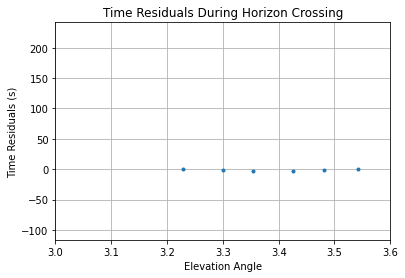

In [6]:
rate_resids = newEn.rate - newEn.rate_model
funcExpect = interpolate.interp1d(newEn.rate, newEn.binTime, fill_value = 'extrapolate')
time_resids = funcExpect(newEn.rate_model) - newEn.binTime
plt.plot(newEn.binnedElev, time_resids, '.')
plt.title('Time Residuals During Horizon Crossing')
plt.xlabel('Elevation Angle')
plt.ylabel('Time Residuals (s)')
plt.xlim(3,3.6)
#plt.ylim(-5,10)
plt.grid()

Mean in Range: 9.14 km
22.266401590457257
44.53280318091451


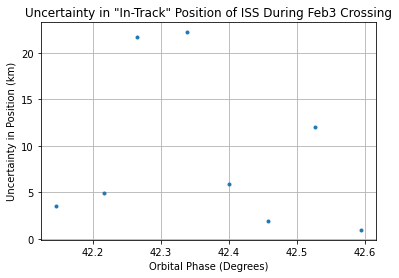

In [7]:
veloc = 7.67 #km/sec
position_error = time_resids*veloc
plt.plot(newEn.binnedPhase[10:18], abs(position_error[10:18]), '.')
plt.title('Uncertainty in "In-Track" Position of ISS During Feb3 Crossing')
plt.ylabel('Uncertainty in Position (km)')
plt.xlabel('Orbital Phase (Degrees)')
plt.grid()
print('Mean in Range: %.2f km' %np.mean(abs(position_error[10:18])))
print(newEn.perc_trans[10])
print(newEn.perc_trans[18])

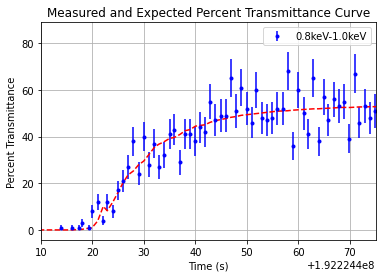

In [8]:
plt.errorbar(newEn.binTime, newEn.rate, fmt='b.', yerr=np.sqrt(newEn.rate), label = f'{newEnRange[0]/100}keV-{newEnRange[1]/100}keV')
plt.plot(newEn.binTime, newEn.rate_model, 'r--')
plt.xlim(410+1.92224e8,475+1.92224e8)
plt.xlabel('Time (s)')
plt.ylabel('Percent Transmittance')
plt.title('Measured and Expected Percent Transmittance Curve')
plt.legend()
plt.grid()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


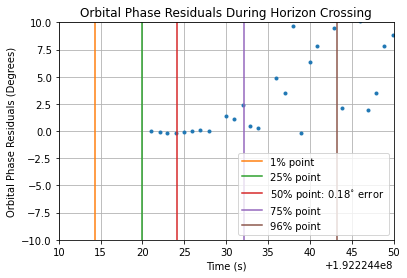

In [9]:
funcExpect = interpolate.interp1d(newEn.rate, newEn.binnedPhase, fill_value = 'extrapolate')
phase_residuals = funcExpect(newEn.rate_model) - newEn.binnedPhase
plt.plot(newEn.binTime, phase_residuals, '.')
plt.plot(np.zeros(10) + (414.33 + 1.92224e8),np.linspace(-10,10,10), label = '1% point')
plt.plot(np.zeros(10) + (419.93 + 1.92224e8),np.linspace(-10,10,10), label = '25% point')
plt.plot(np.zeros(10) + (424.18 + 1.92224e8),np.linspace(-10,10,10), label = r'50% point: $0.18^{\circ}$ error')
plt.plot(np.zeros(10) + (432.16 + 1.92224e8),np.linspace(-10,10,10), label = '75% point')
plt.plot(np.zeros(10) + (443.23 + 1.92224e8),np.linspace(-10,10,10), label = '96% point')
plt.title('Orbital Phase Residuals During Horizon Crossing')
plt.ylabel('Orbital Phase Residuals (Degrees)')
plt.xlabel('Time (s)')
plt.xlim(410 + 1.92224e8, 450 + 1.92224e8)
plt.ylim(-10,10)
plt.grid()
plt.legend(loc='lower right')

Mean in Range: 9.13 km
22.266401590457257
44.53280318091451


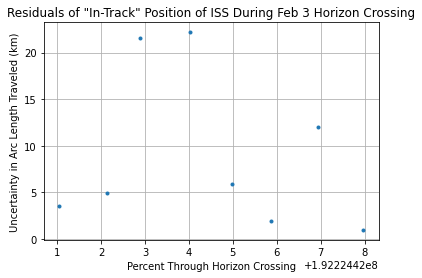

In [10]:
# s=r*theta
arc_error = (R+H)*np.deg2rad(abs(phase_residuals))

plt.plot(newEn.binTime[10:18], arc_error[10:18], '.')
plt.xlabel('Percent Through Horizon Crossing')
plt.ylabel('Uncertainty in Arc Length Traveled (km)')
plt.title('Residuals of "In-Track" Position of ISS During Feb 3 Horizon Crossing')
plt.grid()
print('Mean in Range: %.2f km' %np.mean(abs(arc_error[10:18])))
print(newEn.perc_trans[10])
print(newEn.perc_trans[18])

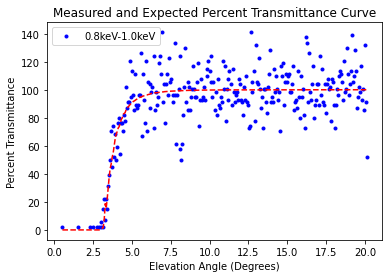

In [11]:
plt.plot(newEn.binnedElev, newEn.perc_trans, 'b.', label = f'{newEnRange[0]/100}keV-{newEnRange[1]/100}keV')
plt.plot(newEn.binnedElev, newEn.trans_model, 'r--')
plt.xlabel('Elevation Angle (Degrees)')
plt.ylabel('Percent Transmittance')
plt.title('Measured and Expected Percent Transmittance Curve')
plt.legend()

In [12]:
def tabulateTrans():
    return np.arange(1, 100, 1)

def tabulateSomething(percTrans, Y):
    func = interpolate.interp1d(percTrans, Y)
    return func(tabulateTrans())
    

tableTrans = tabulateTrans()
tableAlt = tabulateSomething(newEn.trans_model, newEn.new_alt)
tableTime = tabulateSomething(newEn.trans_model, newEn.binTime) - newEn.binTime[0]
tableElev = tabulateSomething(newEn.trans_model, newEn.binnedElev)

For a given orbit and atmosphere (when NICER tracks the source correctly), we expect this tablee to be generalizable, however checking with the jan 31 data may removing the jump out of focus. 

In [13]:
for i in range(0, len(tableAlt)):
    print('%.1f' %tableTrans[i] + str('% crossing') + 
          ': h = %.2fkm, elevation = %.2f degrees | ' %(tableAlt[i], tableElev[i]) +
         'Time Since elevation = 0: %.2f seconds' %tableTime[i])

1.0% crossing: h = 117.27km, elevation = 3.09 degrees | Time Since elevation = 0: 39.33 seconds
2.0% crossing: h = 120.07km, elevation = 3.17 degrees | Time Since elevation = 0: 40.58 seconds
3.0% crossing: h = 120.49km, elevation = 3.18 degrees | Time Since elevation = 0: 40.78 seconds
4.0% crossing: h = 120.91km, elevation = 3.19 degrees | Time Since elevation = 0: 40.98 seconds
5.0% crossing: h = 121.33km, elevation = 3.20 degrees | Time Since elevation = 0: 41.18 seconds
6.0% crossing: h = 121.75km, elevation = 3.22 degrees | Time Since elevation = 0: 41.38 seconds
7.0% crossing: h = 122.16km, elevation = 3.23 degrees | Time Since elevation = 0: 41.59 seconds
8.0% crossing: h = 122.68km, elevation = 3.24 degrees | Time Since elevation = 0: 41.81 seconds
9.0% crossing: h = 123.22km, elevation = 3.26 degrees | Time Since elevation = 0: 42.04 seconds
10.0% crossing: h = 123.76km, elevation = 3.27 degrees | Time Since elevation = 0: 42.27 seconds
11.0% crossing: h = 124.29km, elevation

In [14]:
lowBound = np.where(elevMKF>=2.5)[0][0]
highBound = np.where(elevMKF>=4.9)[0][0]
print(position[lowBound]-position[highBound]) #accuracy of position vector

[0.00646544 0.03344879 0.02401525]


In [15]:
point_dot_s=pointing_unit[:,0]*position[:,0]+pointing_unit[:,1]*position[:,1]+pointing_unit[:,2]*position[:,2]
altAngle = 90-np.rad2deg(np.arccos(point_dot_s))

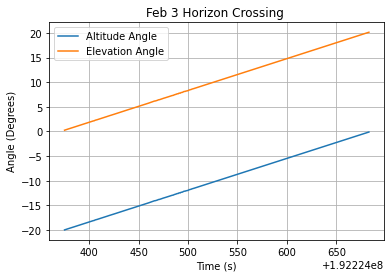

In [16]:
plt.plot(timeMKF, altAngle, label = 'Altitude Angle')
plt.plot(timeMKF, elevMKF, label='Elevation Angle')
plt.title('Feb 3 Horizon Crossing ')
plt.ylabel('Angle (Degrees)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
# These are the two angles that I think best define the basic ide of the horizon crossing.
# The elevation is angle between the line of sight and earth's limb

Text(0.5, 0, 'Time (s)')

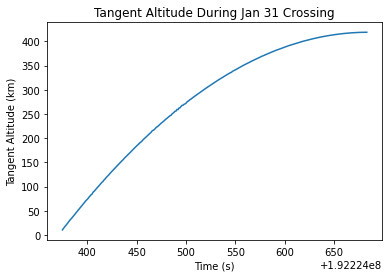

In [17]:
plt.plot(timeMKF, altMKF)
plt.title('Tangent Altitude During Jan 31 Crossing')
plt.ylabel('Tangent Altitude (km)')
plt.xlabel('Time (s)')

In [18]:
# Find the azimuthal angle on the tangent plane of the ISS
p_dot_pos = pointing_unit[:,0]*position[:,0] + pointing_unit[:,1]*position[:,1] + pointing_unit[:,2]*position[:,2]

In [19]:
u_x = []
u_y = []
u_z = []
for i,val in enumerate(p_dot_pos):
    u_x.append([val * position[:,0][i]])
    u_y.append([val * position[:,1][i]])
    u_z.append([val * position[:,2][i]])

u = np.array(u_x)
u = np.append(u, u_y, axis=1)
u = np.append(u, u_z, axis=1)
u = np.array(u)

In [20]:
proj_pointing = pointing_unit - u

proj_x = (proj_pointing[:,0])
proj_y = (proj_pointing[:,1])
proj_z = (proj_pointing[:,2])
proj_mag = np.sqrt((proj_x)**2 + (proj_y)**2 + (proj_z)**2)

proj_dot_v = (proj_pointing[:,0]*velocity[:,0] + proj_pointing[:,1]*velocity[:,1] + proj_pointing[:,2]*velocity[:,2])
azm_angle = np.rad2deg(np.arccos(proj_dot_v/proj_mag))

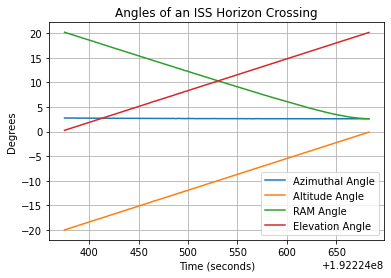

In [21]:
plt.plot(timeMKF, azm_angle, label = 'Azimuthal Angle')
plt.plot(timeMKF, altAngle, label = 'Altitude Angle')
plt.plot(timeMKF, ramMKF, label = 'RAM Angle')
plt.plot(timeMKF, elevMKF, label= 'Elevation Angle')

plt.title('Angles of an ISS Horizon Crossing')
plt.ylabel('Degrees')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()

In [22]:
slope=(elevMKF[len(elevMKF)-1]-elevMKF[0])/(timeMKF[len(timeMKF)-1]-timeMKF[0])
slope

0.0645387637150752

In [23]:
zStar_ISScenter = np.sin(altAngle)
xStar_ISScenter = np.sqrt(((1-(np.sin(azm_angle))**2))/(1+(np.tan(azm_angle))**2))
yStar_ISScenter = xStar_ISScenter*np.tan(azm_angle)
star_ISS_mag = np.sqrt(xStar_ISScenter**2+yStar_ISScenter**2+zStar_ISScenter**2)

In [24]:
# using info from the table to identify location in crossing
t1 = (timeMKF[0]+39.33)-1.92224e8
t100 = (timeMKF[0]+108.17)-1.92224e8

In [25]:
# here, we're trying to do a changing of basis
M_e_to_a = np.array([velocity[0],pole_vec[0],-position[0]]).T
print(pointing_unit[0])
print(np.dot(M_e_to_a,pointing_unit[0]))

[ 0.07644861 -0.900012   -0.4291083 ]
[ 0.34767094  0.45756418 -0.81840193]


In [26]:
alphaStar = 274.84
deltaStar = 27
# change of basis from ECI coords of the source to alt/az coords
xStar_ECI = np.sqrt(((1-(np.sin(alphaStar))**2))/(1+(np.tan(alphaStar))**2))
yStar_ECI = np.sin(np.deg2rad(deltaStar))
zStar_ECI = xStar_ECI*np.tan(alphaStar)
vecECI = np.array([xStar_ECI, yStar_ECI, zStar_ECI]).T

In [27]:
np.dot(M_e_to_a,vecECI)

array([-0.29466928, -0.16894734,  0.30523472])

In [28]:
print(np.sin(orbital_phase[0]))
print(np.cos(orbital_phase[0]))

0.9952749451279816
0.09709677440828367


In [29]:
position[0]

array([-0.6655798,  0.5588614, -0.4946489], dtype=float32)

In [30]:
altitude = betaMKF - 90 # we can get approximate altitude without knowing the position of ISS

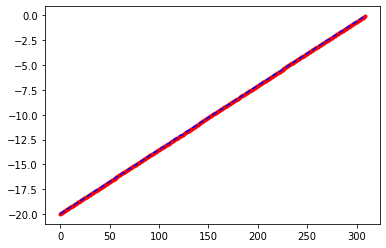

In [31]:
plt.plot(altAngle, 'r.')
plt.plot(altitude, 'b--')

In [32]:
alphaStar - np.rad2deg(azm_angle[0])

116.51121887207029

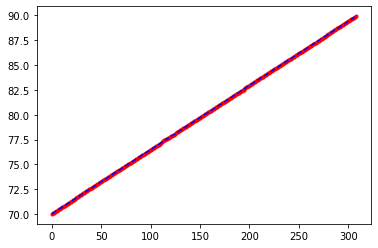

In [33]:
plt.plot(beta, 'r.')
plt.plot(betaMKF, 'b--')

Power_divergenceResult(statistic=49.15446071185696, pvalue=5.9387148302484474e-08)
5.842026825633384
50.909090909090914
70.10432190760059
73.44262295081967
85.9612518628912
23.368107302533534
53.41281669150521


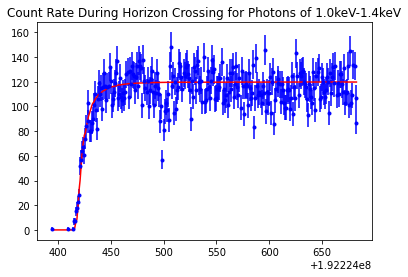

In [34]:
from scipy import stats
plt.errorbar(mid_en.binTime, mid_en.rate, fmt = 'b.', yerr = np.sqrt(mid_en.rate))
plt.plot(mid_en.binTime, mid_en.rate_model, 'r-')
plt.title(f'Count Rate During Horizon Crossing for Photons of {midEn[0]/100}keV-{midEn[1]/100}keV')
#plt.xlim(400+1.92224e8,475+1.92224e8)
print(stats.chisquare(mid_en.rate[4:13], mid_en.rate_model[4:13]))
# 11 pretty accurate points
print(mid_en.perc_trans[4])
print(mid_en.perc_trans[13])
print(mid_en.perc_trans[15])
print(mid_en.perc_trans[16])
print(mid_en.perc_trans[17])

print(mid_en.perc_trans[8])
print(mid_en.perc_trans[11])

272

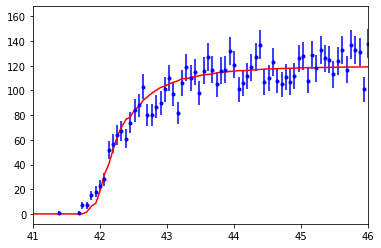

In [35]:
plt.errorbar(mid_en.binnedPhase, mid_en.rate, fmt = 'b.', yerr = np.sqrt(mid_en.rate))
plt.plot(mid_en.binnedPhase, mid_en.rate_model, 'r-')
plt.xlim(41,46)
len(mid_en.binnedPhase)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


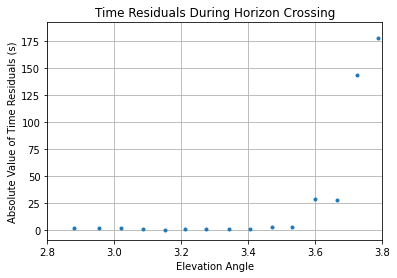

In [36]:
funcExpect = interpolate.interp1d(mid_en.rate, mid_en.binTime, fill_value = 'extrapolate')
time_resids = funcExpect(mid_en.rate_model) - mid_en.binTime

phaseExpect = interpolate.interp1d(mid_en.rate, mid_en.binnedPhase, fill_value = 'extrapolate')
phase_residuals = phaseExpect(mid_en.rate_model) - mid_en.binnedPhase
position_errorPhi = (R+H)*np.deg2rad(phase_residuals)

plt.plot(mid_en.binnedElev, abs(time_resids), '.')
plt.title('Time Residuals During Horizon Crossing')
plt.xlabel('Elevation Angle')
plt.ylabel('Absolute Value of Time Residuals (s)')
plt.xlim(2.8,3.8)

plt.grid()

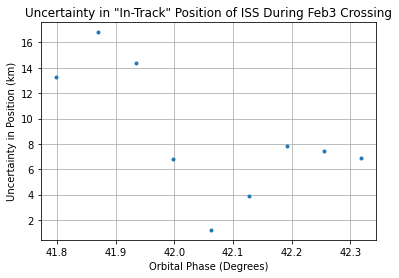

In [37]:
veloc = 7.67 #km/sec
position_error = time_resids*veloc
plt.plot(mid_en.binnedPhase[4:13], abs(position_error[4:13]), '.')
plt.title('Uncertainty in "In-Track" Position of ISS During Feb3 Crossing')
plt.ylabel('Uncertainty in Position (km)')
plt.xlabel('Orbital Phase (Degrees)')
plt.grid()

In [38]:
print('Mean in Range %.2f-%.2f degrees: %.2f km, %.3f km' %(mid_en.binnedPhase[8],mid_en.binnedPhase[11],np.mean(abs(position_error[8:11])),np.mean(abs(position_errorPhi[8:11]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km, %.3f km' %(mid_en.binnedPhase[0],mid_en.binnedPhase[13],np.mean(abs(position_error[4:13])),np.mean(abs(position_errorPhi[4:13]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km, %.3f km' %(mid_en.binnedPhase[0],mid_en.binnedPhase[15],np.mean(abs(position_error[4:15])),np.mean(abs(position_errorPhi[4:15]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km, %.3f km' %(mid_en.binnedPhase[0],mid_en.binnedPhase[16],np.mean(abs(position_error[4:16])),np.mean(abs(position_errorPhi[4:16]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km, %.3f km' %(mid_en.binnedPhase[0],mid_en.binnedPhase[17],np.mean(abs(position_error[4:17])),np.mean(abs(position_errorPhi[4:17]))))
# larger time range vs accuracy. Classify these by angular distance traveled??

Mean in Range 42.06-42.25 degrees: 4.30 km, 4.297 km
Mean in Range 40.42-42.39 degrees: 8.73 km, 8.714 km
Mean in Range 40.42-42.51 degrees: 11.12 km, 11.110 km
Mean in Range 40.42-42.58 degrees: 28.21 km, 28.177 km
Mean in Range 40.42-42.64 degrees: 42.63 km, 42.585 km


In [39]:
print('delta t: %.3f sec' %(mid_en.binTime[11]-mid_en.binTime[8]))
print('delta t: %.3f sec' %(mid_en.binTime[13]-mid_en.binTime[0]))
print('delta t: %.3f sec' %(mid_en.binTime[15]-mid_en.binTime[0]))
print('delta t: %.3f sec' %(mid_en.binTime[16]-mid_en.binTime[0]))
print('delta t: %.3f sec' %(mid_en.binTime[17]-mid_en.binTime[0]))

delta t: 2.973 sec
delta t: 30.568 sec
delta t: 32.492 sec
delta t: 33.561 sec
delta t: 34.485 sec


In [40]:
binSize_all = 1
En1Range = [80,100]
En2Range = [100,140]
En3Range = [160,200]
En4Range = [120,200]
En1 = EnergyBands(En1Range, binSize_all)
En2 = EnergyBands(En2Range, binSize_all)
En3 = EnergyBands(En3Range, binSize_all)
En4 = EnergyBands(En4Range, binSize_all)

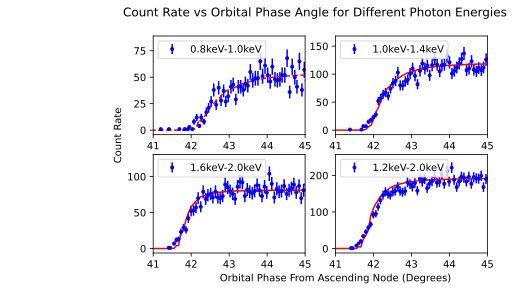

In [41]:
%config InlineBackend.figure_format = 'svg'
fig, axs = plt.subplots(2,2)
plt.suptitle('Count Rate vs Orbital Phase Angle for Different Photon Energies')

axs[0,0].errorbar(En1.binnedPhase, En1.rate, fmt='b.', yerr=np.sqrt(En1.rate), label = f'{En1Range[0]/100}keV-{En1Range[1]/100}keV')
axs[0,0].plot(En1.binnedPhase, En1.rate_model, 'r--')
axs[0,0].set_xlim(41,45)
axs[0,0].legend(loc='upper left')

axs[0,1].errorbar(En2.binnedPhase, En2.rate, fmt='b.', yerr=np.sqrt(En2.rate), label = f'{En2Range[0]/100}keV-{En2Range[1]/100}keV')
axs[0,1].plot(En2.binnedPhase, En2.rate_model, 'r-')
axs[0,1].set_xlim(41,45)
axs[0,1].legend(loc='upper left')

axs[1,0].errorbar(En3.binnedPhase, En3.rate, fmt='b.', yerr=np.sqrt(En3.rate), label = f'{En3Range[0]/100}keV-{En3Range[1]/100}keV')
axs[1,0].plot(En3.binnedPhase, En3.rate_model, 'r-')
axs[1,0].set_ylabel('                                           Count Rate')
axs[1,0].set_xlabel('                                                                   Orbital Phase From Ascending Node (Degrees)')
axs[1,0].set_xlim(41,45)
axs[1,0].legend(loc='upper left')

axs[1,1].errorbar(En4.binnedPhase, En4.rate, fmt='b.', yerr=np.sqrt(En4.rate), label = f'{En4Range[0]/100}keV-{En4Range[1]/100}keV')
axs[1,1].plot(En4.binnedPhase, En4.rate_model, 'r-')
axs[1,1].set_xlim(41,45)
axs[1,1].legend(loc='upper left')


In [42]:
def phaseResids(rate, rate_model, phase):
    func = interpolate.interp1d(rate, phase, fill_value = 'extrapolate')
    phase_residuals = phaseExpect(rate_model) - phase
    return phase_residuals
def phaseResidsPosition(rate, rate_model, phase):
    func = interpolate.interp1d(rate, phase, fill_value = 'extrapolate')
    phase_residuals = phaseExpect(rate_model) - phase
    return (R+H)*np.deg2rad(phase_residuals)

print(np.where(En1.trans_model > 99)[0][0])
En1_error = phaseResidsPosition(En1.rate, En1.rate_model, En1.binnedPhase)
print(stats.chisquare(En1.rate[10:77], En1.rate_model[10:77]))

77
Power_divergenceResult(statistic=113.6279362123216, pvalue=0.00024497651773399515)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [43]:
print(np.where(En2.trans_model > 99)[0][0])
En2_error = phaseResidsPosition(En2.rate, En2.rate_model, En2.binnedPhase)
print(stats.chisquare(En2.rate[4:58], En2.rate_model[4:58]))

58
Power_divergenceResult(statistic=94.37102842291515, pvalue=0.0004089593196897983)


In [44]:
print(np.where(En3.trans_model > 99)[0][0])
En3_error = phaseResidsPosition(En3.rate, En3.rate_model, En3.binnedPhase)
En3_errorPhi = phaseResids(En3.rate, En3.rate_model, En3.binnedPhase)
print(stats.chisquare(En3.rate[4:37], En3.rate_model[4:37]))

37
Power_divergenceResult(statistic=58.27568472735342, pvalue=0.0030516296313130883)


37
Power_divergenceResult(statistic=121.26754648854148, pvalue=3.0001912651810707e-13)


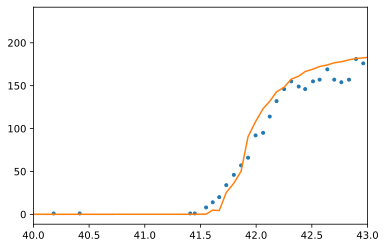

In [45]:
%matplotlib inline
en0=[120,200]
En0 = EnergyBands(en0,binSize_all)
print(np.where(En3.trans_model > 99)[0][0])
plt.plot(En0.binnedPhase, En0.rate, '.')
plt.plot(En0.binnedPhase, En0.rate_model, '-')
plt.xlim(40,43)
print(stats.chisquare(En0.rate[7:37], En0.rate_model[7:37]))

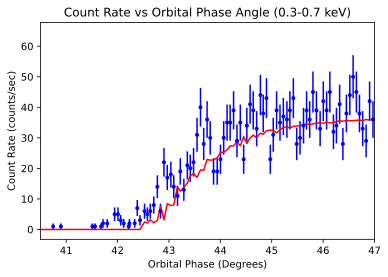

In [46]:
en5=[30,70]
En5 = EnergyBands(en5,binSize_all)
plt.title('Count Rate vs Orbital Phase Angle (0.3-0.7 keV)')
plt.ylabel('Count Rate (counts/sec)')
plt.xlabel('Orbital Phase (Degrees)')
plt.xlim(40.5,47)
plt.errorbar(En5.binnedPhase, En5.rate, fmt='b.', yerr=np.sqrt(En5.rate))
plt.plot(En5.binnedPhase, En5.rate_model, 'r-')

<ErrorbarContainer object of 3 artists>

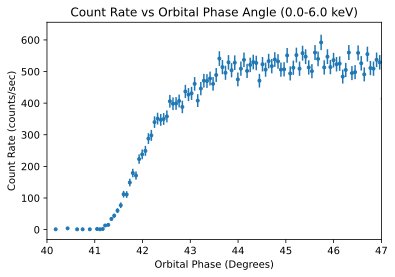

In [47]:
en0=[0,600]
En0 = EnergyBands(en0,binSize_all)
plt.title('Count Rate vs Orbital Phase Angle (0.0-6.0 keV)')
plt.ylabel('Count Rate (counts/sec)')
plt.xlabel('Orbital Phase (Degrees)')
plt.xlim(40,47)
plt.errorbar(En0.binnedPhase, En0.rate, fmt='.', yerr=np.sqrt(En0.rate))

(41.0, 45.0)

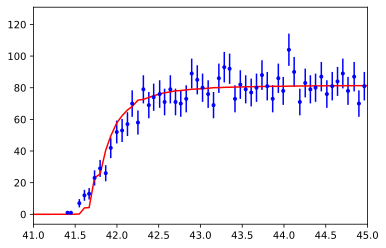

In [48]:
plt.errorbar(En3.binnedPhase, En3.rate, fmt = 'b.', yerr = np.sqrt(En3.rate))
plt.plot(En3.binnedPhase, En3.rate_model, 'r-')
plt.xlim(41,45)

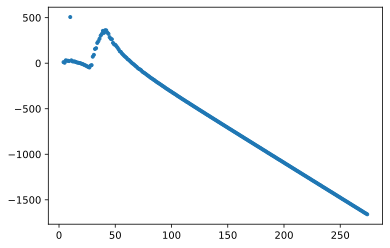

In [49]:
plt.plot(En3_error, '.')

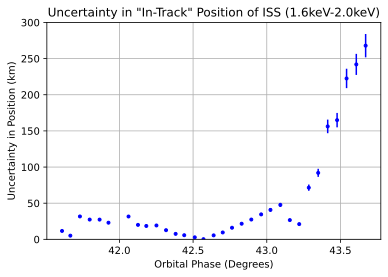

In [50]:
plt.errorbar(En3.binnedPhase[4:37],abs(En3_error[4:37]),yerr=abs(En3_error[4:37])/np.sqrt(len(En3_error)), fmt='b.')
plt.ylim(0,300)
np.mean(En3_error[4:37])
plt.title(f'Uncertainty in "In-Track" Position of ISS ({En3Range[0]/100}keV-{En3Range[1]/100}keV)')
plt.ylabel('Uncertainty in Position (km)')
plt.xlabel('Orbital Phase (Degrees)')
plt.grid()

In [51]:
# if we want to make a nother table for this energy range
print('Mean in Range %.2f-%.2f degrees: %.2f km' %(En3.binnedPhase[8],En3.binnedPhase[11],np.mean(abs(En3_error[8:11]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km' %(En3.binnedPhase[4],En3.binnedPhase[13],np.mean(abs(En3_error[4:13]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km' %(En3.binnedPhase[4],En3.binnedPhase[15],np.mean(abs(En3_error[4:15]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km' %(En3.binnedPhase[4],En3.binnedPhase[16],np.mean(abs(En3_error[4:16]))))
print('Mean in Range %.2f-%.2f degrees: %.2f km' %(En3.binnedPhase[4],En3.binnedPhase[17],np.mean(abs(En3_error[4:17]))))

Mean in Range 41.87-42.06 degrees: 185.72 km
Mean in Range 41.61-42.18 degrees: 76.07 km
Mean in Range 41.61-42.32 degrees: 65.67 km
Mean in Range 41.61-42.38 degrees: 61.25 km
Mean in Range 41.61-42.44 degrees: 57.12 km


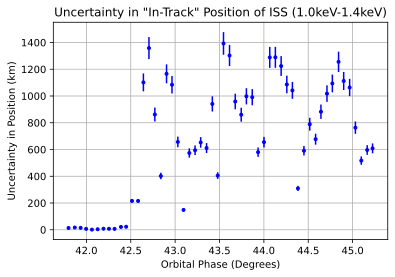

In [52]:
plt.errorbar(En2.binnedPhase[4:58],abs(En2_error[4:58]),yerr=abs(En2_error[4:58])/np.sqrt(len(En2_error)), fmt='b.')
np.mean(En3_error[4:37])
plt.title(f'Uncertainty in "In-Track" Position of ISS ({En2Range[0]/100}keV-{En2Range[1]/100}keV)')
plt.ylabel('Uncertainty in Position (km)')
plt.xlabel('Orbital Phase (Degrees)')
plt.grid()

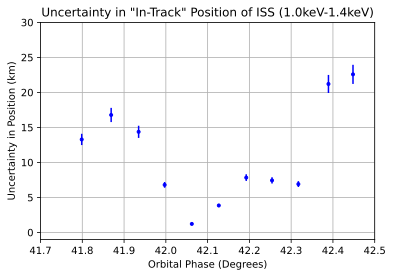

In [53]:
plt.errorbar(En2.binnedPhase[4:58],abs(En2_error[4:58]), fmt='b.',yerr=abs(En2_error[4:58])/np.sqrt(len(En2_error)))
plt.xlim(41.7,42.5)
plt.ylim(-1,30)
plt.title(f'Uncertainty in "In-Track" Position of ISS ({En2Range[0]/100}keV-{En2Range[1]/100}keV)')
plt.ylabel('Uncertainty in Position (km)')
plt.xlabel('Orbital Phase (Degrees)')
plt.grid()

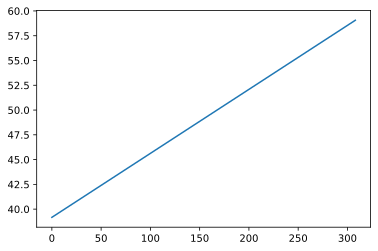

In [54]:
plt.plot(orbital_phase)

In [55]:
# since jan 31, orbital phase for a crossing watching the same source has advanced by about 10 degrees.

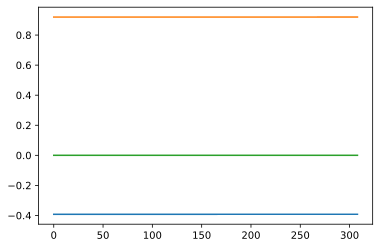

In [56]:
plt.plot(ascending_node)

In [57]:
np.mean(ascending_node[:,0])

-0.39233889489298274

In [58]:
np.mean(ascending_node[:,1])

0.919820733240342

In [59]:
np.mean(ascending_node[:,2])

0.0

In [60]:
orbital_phase[0]

39.17265817664239

In [61]:
orbital_phase[len(orbital_phase)-1]

59.063088320954165

Text(0.5, 0, 'Time (s)')

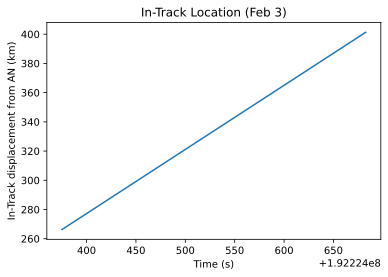

In [62]:
plt.plot(En3.binTime, En3.binnedPhase*(R+H)/1000)
plt.title("In-Track Location (Feb 3)")
plt.ylabel("In-Track displacement from AN (km)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Tangental altitude')

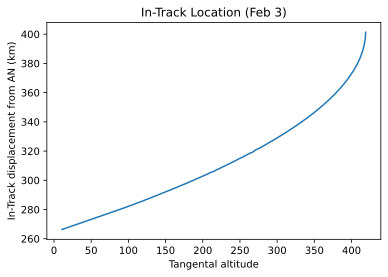

In [63]:
plt.plot(En3.new_alt, En3.binnedPhase*(R+H)/1000)
plt.title("In-Track Location (Feb 3)")
plt.ylabel("In-Track displacement from AN (km)")
plt.xlabel("Tangental altitude")

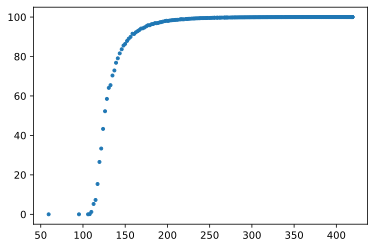

In [71]:
plt.plot(En2.new_alt,En2.trans_model, '.')

In [107]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [108]:
popt, pcov = curve_fit(func, En2.new_alt, En2.trans_model/100)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


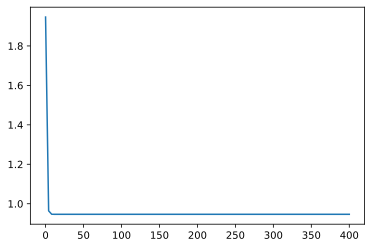

In [109]:
plt.plot(np.linspace(0,400,100),func(np.linspace(0,400,100),*popt))

In [100]:
print(popt)

[1.21087992e-12 9.99999994e-01 1.00000000e+00]


In [110]:
popt

array([1.        , 1.        , 0.94640323])